In [1]:
from pathlib import Path
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
import numpy as np
from IPython.display import display
from conlanger.utils import display_rows


phoible_data_url = "https://raw.githubusercontent.com/phoible/dev/v2.0/data/phoible.csv"
phobile_file_path = "./downloads/phoible.csv"

VALIDATE_RESULTS = True

if not Path(phobile_file_path).exists():
    response = requests.get(phoible_data_url, stream=True)

    with open(phobile_file_path, "wb") as fh:
        for data in tqdm(response.iter_content()):
            fh.write(data)

2024-08-27 18:45:48.314374: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-27 18:45:48.494370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 18:45:48.560998: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 18:45:48.580065: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 18:45:48.708369: I tensorflow/core/platform/cpu_feature_guar

In [2]:
phoible_df = pd.read_csv(phobile_file_path, encoding="utf-8", engine="python")

In [3]:
cons_pl_tbl_df = pd.read_csv(
    "./data/consonants_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
    on_bad_lines="warn",
)
cons_pl_phonemes = cons_pl_tbl_df.stack().replace("", np.nan).dropna().to_numpy()
display(cons_pl_tbl_df)

cons_npl_tbl_df = pd.read_csv(
    "./data/consonants_non_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)
cons_npl_phonemes = cons_npl_tbl_df.stack().replace("", np.nan).dropna().to_numpy()
display(cons_npl_tbl_df)

cons_coart_tbl_df = pd.read_csv(
    "./data/consonants_coarticulated.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)
cons_coart_phonemes = cons_coart_tbl_df.stack().replace("", np.nan).dropna().to_numpy()
display(cons_coart_tbl_df)

vowels_tbl_df = pd.read_csv(
    "./data/vowels.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)
vowels_phonemes = vowels_tbl_df.stack().replace("", np.nan).dropna().to_numpy()
display(vowels_tbl_df)

,Bilabial,Bilabial_v,Labiodental,Labiodental_v,Linguolabial,Linguolabial_v,Dental,Dental_v,Alveolar,Alveolar_v,...,Palatal,Palatal_v,Velar,Velar_v,Uvular,Uvular_v,Pharyngeal,Pharyngeal_v,Glottal,Glottal_v
Nasal,m̥,m,ɱ̊,ɱ,,n̼,,,n̥,n,...,ɲ̊,ɲ,ŋ̊,ŋ,ɴ̥,ɴ,NaN,NaN,NaN,NaN
Plosive,p,b,p̪,b̪,t̼,d̼,t̪,d̪,t,d,...,c,ɟ,k,ɡ,q,ɢ,,NaN,ʔ,NaN
Sibilant affricate,NaN,NaN,NaN,NaN,NaN,NaN,,,ts,dz,...,tɕ,dʑ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Non-sibilant affricate,pɸ,bβ,p̪f,b̪v,,,t̪θ,d̪ð,tɹ̝̊,dɹ̝,...,cç,ɟʝ,kx,ɡɣ,qχ,ɢʁ,ʡʜ,ʡʢ,ʔh,
Sibilant fricative,NaN,NaN,NaN,NaN,NaN,NaN,,,s,z,...,ɕ,ʑ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Non-sibilant fricative,ɸ,β,f,v,θ̼,ð̼,θ,ð,θ̠,ð̠,...,ç,ʝ,x,ɣ,χ,ʁ,ħ,ʕ,h,ɦ
Approximant,,,ʋ̥,ʋ,,ð̼˕,,,,ɹ,...,,j,,ɰ,,,,,,ʔ̞
Tap/flap,,ⱱ̟,,ⱱ,,ɾ̼,,,ɾ̥,ɾ,...,,,,,,ɢ̆,,ʡ̆,,
Trill,ʙ̥,ʙ,,,,,,,r̥,r,...,,,NaN,NaN,ʀ̥,ʀ,ʜ,ʢ,NaN,NaN
Fricative,ɸ,β,f,v,θ̼,ð̼,θ,ð,s,z,...,ç,ʝ,x,ɣ,χ,ʁ,ħ,ʕ,h,ɦ


,Bilabial,Labiodental,Dental,Alveolar,Palato-alveolar,Retroflex,Palatal,Velar,Uvular,Pharyngeal
Ejective Stop,pʼ,,t̪ʼ,tʼ,,ʈʼ,cʼ,kʼ,qʼ,ʡʼ
Ejective Fricative,,fʼ,θʼ,sʼ,ʃʼ,ʂʼ,ɕʼ,xʼ,χʼ,
Ejective Affricate,,,,tsʼ,t̠ʃʼ,ʈʂʼ,,kxʼ,qχʼ,
Ejective Lateral,,,,ɬʼ,tɬʼ,,cʎ̝̊ʼ,kʟ̝̊ʼ,,
Click,ʘ,,ǀ,ǃ,,,ǂ,ǁ,,
Implosive Voiced,ɓ,,,ɗ,,ᶑ,ʄ,ɠ,ʛ,
Implosive Voiceless,ɓ̥,,,ɗ̥,,ᶑ̥,ʄ̥,ɠ̊,ʛ̥,


,Labial–palatal,Labial–velar,Velarized alveolar,Palatal-velar
Fricative,ɥ̊,ʍ,,ɧ
Approximant,ɥ,w,,
Lateral approximant,,,ɫ,


,Front unrounded,Front rounded,Near-front unrounded,Near-front rounded,Central unrounded,Central rounded,Near-back unrounded,Near-back rounded,Back unrounded,Back rounded
Close,i,y,,,ɨ,ʉ,,,ɯ,u
Near-close,,,ɪ,ʏ,,,,ʊ,,
Close-mid,e,ø,,,ɘ,ɵ,,,ɤ,o
Mid,e̞,ø̞,,,ə,,,,ɤ̞,o̞
Open-mid,ɛ,œ,,,ɜ,ɞ,,,ʌ,ɔ
Near-open,æ,,,ɐ,,,,,,
Open,a,ɶ,,,ä,,,,ɑ,ɒ


In [4]:
all_table_phonemes = np.concatenate(
    [cons_pl_phonemes, cons_npl_phonemes, cons_coart_phonemes, vowels_phonemes]
)
all_table_phonemes.shape

(254,)

In [5]:
phonemes_df = (
    phoible_df[phoible_df.Phoneme.isin(set(all_table_phonemes))][
        ["LanguageName", "SpecificDialect", "Phoneme"]
    ]
    .copy()
    .fillna({"SpecificDialect": "none"})
    .drop_duplicates()
)

phoneme_counts = phonemes_df.Phoneme.value_counts().to_dict()

lang_by_dialect_df = phonemes_df.groupby(["LanguageName", "SpecificDialect"])

language_names_by_dialect = (
    phoible_df[["LanguageName", "SpecificDialect"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .LanguageName.to_numpy()
)

phoible_df.shape, phonemes_df.shape, language_names_by_dialect.shape

((105467, 48), (69882, 3), (2949,))

In [6]:
def create_symbol_matrix(phoneme_tbl_df):
    zeros = np.zeros(phoneme_tbl_df.shape).astype(np.float16)
    ones = np.ones(phoneme_tbl_df.shape).astype(np.float16)

    def map_table(dialect_df):
        phonemes = set(dialect_df.Phoneme.values)
        # this should return a matrix of shape phoneme_tbl_df.shape
        return np.where(phoneme_tbl_df.map(lambda x: x in phonemes), ones, zeros)

    return map_table


cons_pl_npy = np.stack(
    lang_by_dialect_df.apply(
        create_symbol_matrix(cons_pl_tbl_df), include_groups=False
    ).to_numpy()
)
cons_npl_npy = np.stack(
    lang_by_dialect_df.apply(
        create_symbol_matrix(cons_npl_tbl_df), include_groups=False
    ).to_numpy()
)
cons_coart_npy = np.stack(
    lang_by_dialect_df.apply(
        create_symbol_matrix(cons_coart_tbl_df), include_groups=False
    ).to_numpy()
)
vowels_npy = np.stack(
    lang_by_dialect_df.apply(
        create_symbol_matrix(vowels_tbl_df), include_groups=False
    ).to_numpy()
)

assert cons_pl_npy.shape == (language_names_by_dialect.shape[0], *cons_pl_tbl_df.shape)
assert cons_npl_npy.shape == (language_names_by_dialect.shape[0], *cons_npl_tbl_df.shape)
assert cons_coart_npy.shape == (language_names_by_dialect.shape[0], *cons_coart_tbl_df.shape)
assert vowels_npy.shape == (language_names_by_dialect.shape[0], *vowels_tbl_df.shape)


(
    cons_pl_npy.shape,
    cons_npl_npy.shape,
    cons_coart_npy.shape,
    vowels_npy.shape,
)

((2949, 14, 24), (2949, 7, 10), (2949, 3, 4), (2949, 7, 10))

For languages that have multiple samples in the Phoible dataset, we pick just one sample. Based on previous analysis, the best option seems to be to just pick the one whith the most phonemes per language, as this generally has more information (for example long and short versions of the phonemes).

In [7]:
unique_names = np.unique(language_names_by_dialect)

cons_pl_selected = np.array(
    [np.max(cons_pl_npy[language_names_by_dialect == name], axis=0) for name in unique_names]
)
cons_npl_selected = np.array(
    [np.max(cons_npl_npy[language_names_by_dialect == name], axis=0) for name in unique_names]
)
cons_coart_selected = np.array(
    [np.max(cons_coart_npy[language_names_by_dialect == name], axis=0) for name in unique_names]
)
vowels_selected = np.array(
    [np.max(vowels_npy[language_names_by_dialect == name], axis=0) for name in unique_names]
)

# sense check
for name in unique_names:
    assert cons_pl_npy[language_names_by_dialect == name].shape[1:] == cons_pl_selected.shape[1:]
    assert cons_npl_npy[language_names_by_dialect == name].shape[1:] == cons_npl_selected.shape[1:]
    assert cons_coart_npy[language_names_by_dialect == name].shape[1:] == cons_coart_selected.shape[1:]
    assert vowels_npy[language_names_by_dialect == name].shape[1:] == vowels_selected.shape[1:]

cons_pl_selected.shape, cons_npl_selected.shape, cons_coart_selected.shape, vowels_selected.shape, unique_names.shape

((2740, 14, 24), (2740, 7, 10), (2740, 3, 4), (2740, 7, 10), (2740,))

In [8]:
def make_img_matrix(cons_pl, cons_npl, cons_coart, vowels, fill_value=0):
    max_cols = max(
        cons_pl.shape[2],
        cons_npl.shape[2],
        cons_coart.shape[2],
        vowels.shape[2],
    )

    def get_padding(arr, rows=None, cols=None):
        row_padding = 0 if rows is None else rows - arr.shape[1]
        col_padding = 0 if cols is None else cols - arr.shape[2]
        return ((0, 0), (0, row_padding), (0, col_padding))
    
    cons_npl_padded = np.pad(
                cons_npl,
                get_padding(cons_npl, rows=vowels.shape[1]),
                mode="constant",
            )
    
    cons_coart_padded = np.pad(
                cons_coart,
                get_padding(cons_coart, rows=vowels.shape[1]),
                mode="constant",
            )

    row2 = np.dstack(
        [
            cons_npl_padded,
            cons_coart_padded,
            vowels,
        ]
    )

    return np.hstack(
        [
            cons_pl,
            np.full((cons_pl.shape[0], 1, max_cols), fill_value),
            np.pad(
                row2,
                get_padding(row2, cols=max_cols),
                mode="constant",
            ),
        ]
    )


language_phonemes_all = make_img_matrix(
    cons_pl_npy,
    cons_npl_npy,
    cons_coart_npy,
    vowels_npy,
)
language_phonemes_selected = make_img_matrix(
    cons_pl_selected,
    cons_npl_selected,
    cons_coart_selected,
    vowels_selected,
)

np.savez_compressed(
    "./data/language_phonemes.npz",
    language_phonemes_selected=language_phonemes_selected,
    language_names_selected=unique_names,
)

np.savez_compressed(
    "./data/language_phonemes_all.npz",
    language_phonemes_all=language_phonemes_all,
    language_names_all=language_names_by_dialect,
)

(
    language_phonemes_all.shape,
    language_names_by_dialect.shape,
    language_phonemes_selected.shape,
    unique_names.shape,
)

((2949, 22, 24), (2949,), (2740, 22, 24), (2740,))

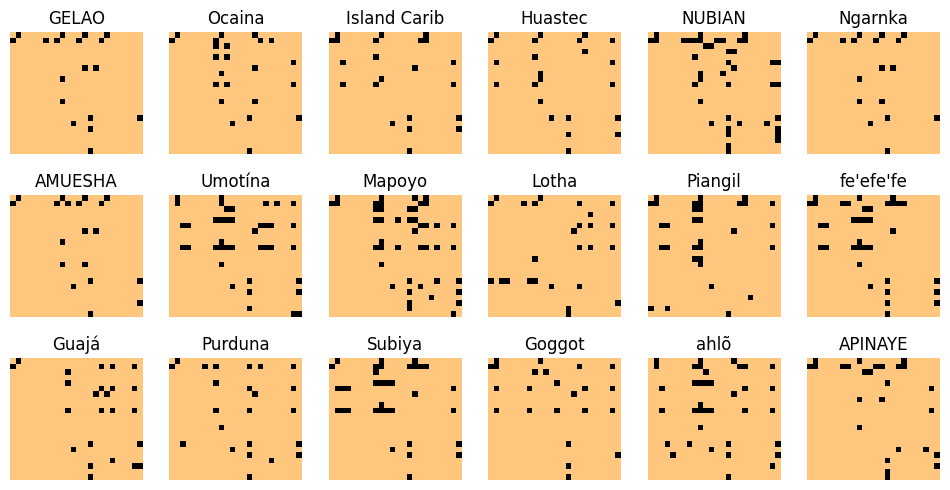

array([ 655, 1709,  877,  815, 1557, 1621,   24, 2230, 1393, 1284, 1794,
       2573,  725, 1827, 2028,  711, 2511,   31])

In [9]:
import matplotlib.pyplot as plt

r, c = 3, 6

gen = np.random.default_rng()
sample_indices = gen.choice(unique_names.size, r * c, replace=False)
samples = language_phonemes_selected[sample_indices]
sample_names = unique_names[sample_indices]

display_rows(samples, titles=sample_names, cmap="copper_r", r=r, c=c, size=(12, 6))

sample_indices

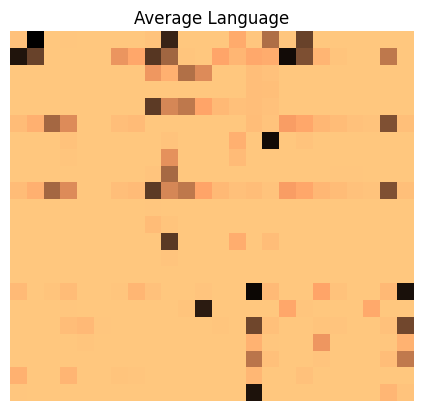

In [10]:
# what does an average language look like?
mean_lang = np.mean(language_phonemes_selected, axis=0)

fig = plt.imshow(
    mean_lang,
    cmap=plt.get_cmap("copper_r"),
    vmin=np.min(mean_lang),
    vmax=np.max(mean_lang),
)
plt.axis("off")
plt.title("Average Language")
plt.show()

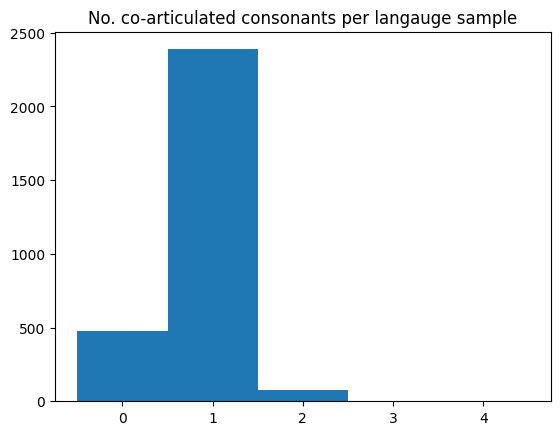

(2949, 3, 4) (2470, 3, 4) (479, 3, 4)
['ɥ̊' 'ʍ' 'ɧ' 'ɥ' 'w' 'ɫ']
[]


In [11]:
# languages with coarticulated consonants

# this doesn't seem correct#
# only w seems present in the majority of samples

coart_counts = np.sum(cons_coart_npy, axis=(1, 2))

coart_present = cons_coart_npy[coart_counts > 0]
coart_not_present = cons_coart_npy[coart_counts == 0]

plt.hist(coart_counts, bins=[0, 1, 2, 3, 4, 5], align='left')
plt.xticks(range(5))
plt.title("No. co-articulated consonants per langauge sample")
plt.show()

print(cons_coart_npy.shape, coart_present.shape, coart_not_present.shape)

unique_phoible_phonemes = phonemes_df.Phoneme.unique()

print(cons_coart_phonemes[np.isin(cons_coart_phonemes, unique_phoible_phonemes)])
print(cons_coart_phonemes[~np.isin(cons_coart_phonemes, unique_phoible_phonemes)])

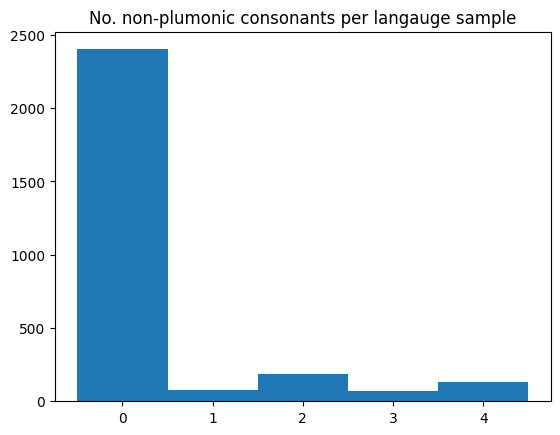

(2949, 7, 10) (547, 7, 10) (2402, 7, 10)
['pʼ' 't̪ʼ' 'tʼ' 'ʈʼ' 'cʼ' 'kʼ' 'qʼ' 'fʼ' 'θʼ' 'sʼ' 'ʃʼ' 'ʂʼ' 'ɕʼ' 'xʼ'
 'χʼ' 'tsʼ' 't̠ʃʼ' 'ʈʂʼ' 'kxʼ' 'qχʼ' 'ɬʼ' 'tɬʼ' 'ɓ' 'ɗ' 'ᶑ' 'ʄ' 'ɠ' 'ɓ̥'
 'ɗ̥' 'ʄ̥' 'ʛ̥']
['ʡʼ' 'cʎ̝̊ʼ' 'kʟ̝̊ʼ' 'ʘ' 'ǀ' 'ǃ' 'ǂ' 'ǁ' 'ʛ' 'ᶑ̥' 'ɠ̊']


In [12]:
# languages with non  conplumonicsonants

# this doesn't seem correct#
# only w seems present in the majority of samples

npl_counts = np.sum(cons_npl_npy, axis=(1, 2))

npl_present = cons_npl_npy[npl_counts > 0]
npl_not_present = cons_npl_npy[npl_counts == 0]

plt.hist(npl_counts, bins=[0, 1, 2, 3, 4, 5], align='left')
plt.xticks(range(5))
plt.title("No. non-plumonic consonants per langauge sample")
plt.show()

print(cons_npl_npy.shape, npl_present.shape, npl_not_present.shape)

unique_phoible_phonemes = phonemes_df.Phoneme.unique()

print(cons_npl_phonemes[np.isin(cons_npl_phonemes, unique_phoible_phonemes)])
print(cons_npl_phonemes[~np.isin(cons_npl_phonemes, unique_phoible_phonemes)])